In [1]:
# System
import os
#nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# Tools
import itertools
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

# NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from pywsd.utils import lemmatize_sentence

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import re

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_val_predict

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_csv('data/twitter_sentiment_data.csv')
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [3]:
# checking very common words and dropping them
freq = pd.Series(' '.join(df['message']).split()).value_counts()[:10]
freq

climate    31214
RT         25261
change     23137
to         18454
the        17489
of         11536
is         11303
a           9866
global      9679
in          8829
dtype: int64

In [4]:
# dropping these frequent common words even before using stop words and other data cleaning steps
freq = list(freq.index)
df['message'] = df['message'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['message'].head()

0    @tiniebeany an interesting hustle as it was wa...
1    @NatGeoChannel: Watch #BeforeTheFlood right he...
2    Fabulous! Leonardo #DiCaprio's film on #climat...
3    @Mick_Fanning: Just watched this amazing docum...
4    @cnalive: Pranita Biswasi, Lutheran from Odish...
Name: message, dtype: object

### Data Cleaning

This exercise to understand the most popular tweets and topics using hashtag analysis as well as topic modeling using LDA and NMF

In [5]:
# making a new column to highlight the re-tweets
df['is_retweet'] = df['message'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # getting the number of retweets

15

In [6]:
# 10 most repeated tweets
df.groupby(['message']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,message,counts
14243,@StephenSchlegel: she's thinking about how she...,506
13728,@SenSanders: We have president-elect who doesn...,213
11067,@NatGeoChannel: Watch #BeforeTheFlood right he...,141
13838,@SethMacFarlane: HRC proposes installing half ...,110
2823,@BernieSanders: #ImVotingBecause future planet...,89
2824,@BernieSanders: 'The concept warming was creat...,81
3669,@CNN: No snow where there should be. Bleached ...,53
13730,@SenSanders: We have president-elect who doesn...,53
19157,"@ddlovato: #IVotedBecause I believe equality, ...",52
13676,@SenSanders: If we don't address there'll be m...,44


In [7]:
# Defining functions to get re-tweets, whenever someone is mentioned and to find hashtags
def find_retweets(message):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', message)

def find_mentioned(message):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', message)  

def find_hashtags(message):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', message)   

In [8]:
# making new columns for re-tweet usernames , mentioned usernames and hashtags
df['re-tweeted'] = df.message.apply(find_retweets)
df['mentioned'] = df.message.apply(find_mentioned)
df['hashtags'] = df.message.apply(find_hashtags)
df.head()

,sentiment,message,tweetid,is_retweet,re-tweeted,mentioned,hashtags
0,-1,@tiniebeany an interesting hustle as it was wa...,792927353886371840,False,[],[@tiniebeany],[]
1,1,@NatGeoChannel: Watch #BeforeTheFlood right he...,793124211518832641,False,[],"[@NatGeoChannel, @LeoDiCaprio]",[#BeforeTheFlood]
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,False,[],[@youtube],"[#DiCaprio, #climate]"
3,1,@Mick_Fanning: Just watched this amazing docum...,793124635873275904,False,[],[@Mick_Fanning],[]
4,2,"@cnalive: Pranita Biswasi, Lutheran from Odish...",793125156185137153,False,[],[@cnalive],[]


In [9]:
# taking only the rows from the hashtag column where there are actually hashtags
hashtags_listdf = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_listdf.head()

,hashtags
1,[#BeforeTheFlood]
2,"[#DiCaprio, #climate]"
7,"[#DonaldTrump, #monaco]"
8,"[#INDIGENOUS, #TAIRP]"
9,"[#BeforeTheFlood, #BeforeTheFlood]"


In [10]:
# creating dataframe where each use of hashtag gets its own row
one_hashtag_one_row = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_listdf.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
one_hashtag_one_row.head()

,hashtag
0,#BeforeTheFlood
1,#DiCaprio
2,#climate
3,#DonaldTrump
4,#monaco


In [11]:
# counting appearances of each hashtag
popular_df = one_hashtag_one_row.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_df.head()

,hashtag,counts
0,#climate,890
1,#climatechange,461
2,#BeforeTheFlood,248
3,#ClimateChange,156
4,#ActOnClimate,146


In [12]:
# take hashtags which appear at least this amount of times
min_appearance = 40
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_df[
                           popular_df.counts>=min_appearance
                           ]['hashtag'])
#print(popular_hashtags_set)

In [13]:
# make a new column with only the popular hashtags
hashtags_listdf['popular_hashtags'] = hashtags_listdf.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_df = hashtags_listdf.loc[
            hashtags_listdf.popula_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_df.head()

,hashtags,popular_hashtags
1,[#BeforeTheFlood],[#BeforeTheFlood]
2,"[#DiCaprio, #climate]",[#climate]
9,"[#BeforeTheFlood, #BeforeTheFlood]","[#BeforeTheFlood, #BeforeTheFlood]"
12,[#BeforeTheFlood],[#BeforeTheFlood]
14,"[#climate, #BeforeTheFlood]","[#climate, #BeforeTheFlood]"


In [14]:
# make new dataframe
hashtag_vector = popular_hashtags_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector['{}'.format(hashtag)] = hashtag_vector.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_vector.head()

,popular_hashtags,#science,#IVotedBecause,#p2,#ParisAgreement,#environment,#cdnpoli,#Trump,#ImVotingBecause,#auspol,...,#globalwarming,#Climate,#BeforeTheFlood,#news,#climatechange,#climate,#tcot,#COP22,#ActOnClimate,#COP21
1,[#BeforeTheFlood],0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,[#climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,"[#BeforeTheFlood, #BeforeTheFlood]",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,[#BeforeTheFlood],0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14,"[#climate, #BeforeTheFlood]",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


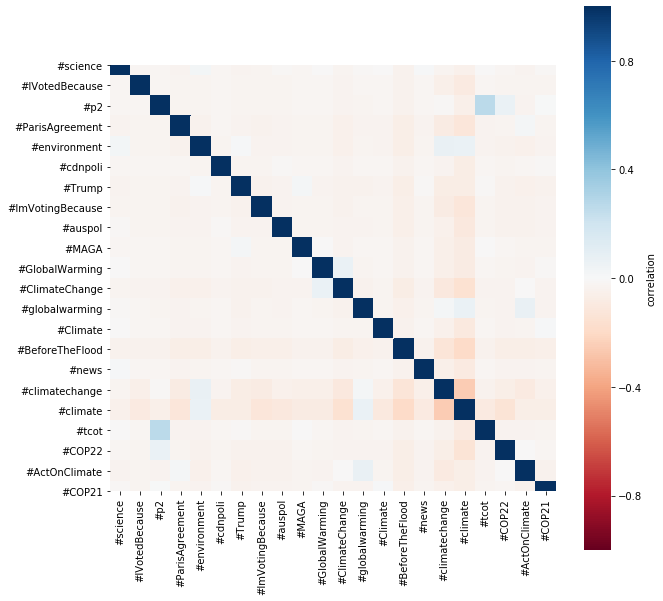

In [15]:
hashtag_matrix = hashtag_vector.drop('popular_hashtags', axis=1)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

### Topic Modelling

In [16]:
def remove_link(message):
    '''Takes a string and removes web links from it'''
    message = re.sub(r'http\S+', '', message) # removing http links
    message = re.sub(r'bit.ly/\S+', '', message) # removing bitly links
    message = message.strip('[link]') # remove [links]
    return message

def remove_user(message):
    '''Takes a string and removes retweet and @user information'''
    message = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', message) # removing retweet
    message = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', message) # removing tweeted at
    return message

In [17]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_router = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punct= '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(message, bigrams=False):
    message = remove_user(message)
    message = remove_link(message)
    message = message.lower() # lower case
    message = re.sub('['+my_punct + ']+', ' ', message) # strip punctuation
    message = re.sub('\s+', ' ', message) #remove double spacing
    message = re.sub('([0-9]+)', '', message) # remove numbers
    tweet_token_list = [word for word in message.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_router(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    message = ' '.join(tweet_token_list)
    return message

In [42]:
df['clean_text'] = df.message.apply(clean_tweet)
df.head()

,sentiment,message,tweetid,is_retweet,re-tweeted,mentioned,hashtags,clean_text
0,-1,@tiniebeany an interesting hustle as it was wa...,792927353886371840,False,[],[@tiniebeany],[],interest hustl warm planet stop warm ye suv ...
1,1,@NatGeoChannel: Watch #BeforeTheFlood right he...,793124211518832641,False,[],"[@NatGeoChannel, @LeoDiCaprio]",[#BeforeTheFlood],watch #beforetheflood right travel world tack...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,False,[],[@youtube],"[#DiCaprio, #climate]",fabul leonardo #dicaprio film #climate brillia...
3,1,@Mick_Fanning: Just watched this amazing docum...,793124635873275904,False,[],[@Mick_Fanning],[],watch amaz documentari leonardodicaprio chang...
4,2,"@cnalive: Pranita Biswasi, Lutheran from Odish...",793125156185137153,False,[],[@cnalive],[],pranita biswasi lutheran odisha give testimon...


In [43]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()


In [44]:
number_of_topics = 20

topmodel1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [49]:
topmodel2 = NMF(n_components=number_of_topics, random_state=0,alpha=.1,l1_ratio=0.2, max_iter=300)

In [45]:
topmodel1.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [50]:
topmodel2.fit(tf)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.2, max_iter=300,
    n_components=20, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [46]:
def to_display_topics(topmodel, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(topmodel.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [47]:
no_top_words = 20
to_display_topics(topmodel1, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,human,774.1,fight,1327.9,warm,3602.2,go,1351.1,€¦,1964.8,...,know,925.3,u,494.4,¢â‚¬â¦,800.3,like,868.3,trump,1095.8
1,chang,752.8,chang,967.3,global,1175.5,think,1302.1,warm,746.1,...,chang,599.9,end,466.4,right,769.9,â,615.6,chang,579.7
2,new,522.3,…,543.2,weather,613.7,die,882.9,chang,648.1,...,planet,575.1,warm,414.2,world,701.5,look,499.4,nation,577.2
3,caus,407.0,pari,382.3,…,436.0,believ,638.6,€™,593.8,...,futur,471.0,¢â‚¬â¦,345.6,ã,506.7,ice,436.0,report,519.1
4,…,403.6,’t,381.0,blame,408.3,husband,530.0,â,571.5,...,combat,335.4,first,342.8,watch,457.6,€¦,363.0,…,498.0
5,oil,383.3,care,312.7,scientist,294.2,use,391.7,much,410.5,...,countri,290.4,creat,331.9,must,442.1,denial,351.6,polici,439.0
6,studi,369.9,help,303.4,fake,288.4,discuss,335.0,one,397.5,...,¢â‚¬â¦,272.6,make,331.2,amp,436.9,arctic,283.5,obama,382.5
7,research,321.0,govern,300.9,news,284.0,exxon,277.5,stop,374.7,...,¢â‚¬â„¢,251.9,billion,312.2,tackl,413.2,chang,250.2,deal,322.9
8,warm,289.6,agreement,265.3,data,246.4,chang,238.3,threat,327.5,...,trump,250.5,trump,301.0,chang,404.1,…,229.5,sign,313.8
9,citi,287.3,pope,232.9,call,234.2,problem,208.4,€™t,276.7,...,hillari,236.0,term,258.7,leader,382.2,record,227.5,secur,313.5


In [51]:
to_display_topics(topmodel2, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,chang,15.2,warm,13.0,q,10.8,â,10.0,…,12.4,...,real,8.5,caus,5.3,like,8.0,fight,8.5,world,8.1
1,combat,0.3,global,1.4,global,0.4,€,0.6,change,0.5,...,know,1.1,epa,4.9,look,1.8,via,1.3,new,2.1
2,deni,0.3,make,0.4,obama,0.2,ã,0.5,scienc,0.3,...,need,0.8,pruitt,2.6,peopl,1.1,help,1.0,right,1.7
3,action,0.3,weather,0.3,pope,0.1,€™,0.5,scientist,0.3,...,scientist,0.5,human,2.2,snow,0.6,could,0.5,tackl,1.4
4,talk,0.3,year,0.3,let,0.1,€“,0.2,one,0.3,...,equal,0.3,scott,2.2,ice,0.5,want,0.4,watch,1.3
5,due,0.3,stop,0.3,one,0.1,€”,0.2,htt,0.3,...,immigr,0.3,head,1.6,thing,0.5,need,0.4,leader,1.2
6,#climate,0.2,u,0.3,said,0.1,changeâ,0.1,denier,0.2,...,pro,0.3,carbon,1.6,bleach,0.4,citi,0.4,#beforetheflood,1.0
7,stop,0.2,earth,0.3,time,0.1,call,0.1,time,0.2,...,reform,0.3,deni,1.4,crack,0.4,way,0.3,travel,1.0
8,want,0.2,degre,0.2,call,0.1,warmingâ,0.1,talk,0.2,...,choic,0.3,chief,1.3,anemon,0.4,energi,0.3,httã,0.9
9,one,0.2,chines,0.2,planet,0.1,€œclimat,0.1,year,0.2,...,still,0.3,dioxid,1.2,deni,0.4,ã,0.3,countri,0.6
